# Project 6: Reducing Noise by Strategically Reducing the Vocabulary
## Further Noise Reduction
### Importing previous step

In [1]:
from Project2 import *
import warnings
warnings.filterwarnings('ignore')

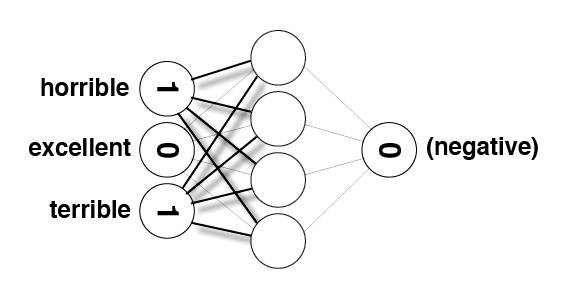

In [2]:
Image(filename='sentiment_network_sparse_2.png')

In [3]:
# words most frequently seen in a review with a "POSITIVE" label
pos_neg_ratios.most_common()[:30]

[('edie', 4.6913478822291435),
 ('paulie', 4.07753744390572),
 ('felix', 3.152736022363656),
 ('polanski', 2.8233610476132043),
 ('matthau', 2.80672172860924),
 ('victoria', 2.681021528714291),
 ('mildred', 2.6026896854443837),
 ('gandhi', 2.538973871058276),
 ('flawless', 2.451005098112319),
 ('superbly', 2.26002547857525),
 ('perfection', 2.159484249353372),
 ('astaire', 2.1400661634962708),
 ('captures', 2.038619547159581),
 ('voight', 2.030170492673053),
 ('wonderfully', 2.0218960560332353),
 ('powell', 1.978345424808467),
 ('brosnan', 1.9547990964725592),
 ('lily', 1.9203768470501485),
 ('bakshi', 1.9029851043382795),
 ('lincoln', 1.9014583864844796),
 ('refreshing', 1.8551812956655511),
 ('breathtaking', 1.8481124057791867),
 ('bourne', 1.8478489358790986),
 ('lemmon', 1.8458266904983307),
 ('delightful', 1.8002701588959635),
 ('flynn', 1.7996646487351682),
 ('andrews', 1.7764919970972666),
 ('homer', 1.7692866133759964),
 ('beautifully', 1.7626953362841438),
 ('soccer', 1.757857

In [4]:
# words most frequently seen in a review with a "NEGATIVE" label
list(reversed(pos_neg_ratios.most_common()))[0:30]

[('boll', -4.969813299576001),
 ('uwe', -4.624972813284271),
 ('seagal', -3.644143560272545),
 ('unwatchable', -3.258096538021482),
 ('stinker', -3.2088254890146994),
 ('mst', -2.9502698994772336),
 ('incoherent', -2.9368917735310576),
 ('unfunny', -2.6922395950755678),
 ('waste', -2.6193845640165536),
 ('blah', -2.5704288232261625),
 ('horrid', -2.4849066497880004),
 ('pointless', -2.4553061800117097),
 ('atrocious', -2.4259083090260445),
 ('redeeming', -2.3682390632154826),
 ('prom', -2.3608540011180215),
 ('drivel', -2.3470368555648795),
 ('lousy', -2.307572634505085),
 ('worst', -2.286987896180378),
 ('laughable', -2.264363880173848),
 ('awful', -2.227194247027435),
 ('poorly', -2.2207550747464135),
 ('wasting', -2.204604684633842),
 ('remotely', -2.1972245773362196),
 ('existent', -2.0794415416798357),
 ('boredom', -1.995100393246085),
 ('miserably', -1.9924301646902063),
 ('sucks', -1.987068221548821),
 ('uninspired', -1.9832976811269336),
 ('lame', -1.981767458946166),
 ('insult

In [5]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [6]:
hist, edges = np.histogram(list(map(lambda x:x[1],pos_neg_ratios.most_common())), density=True, bins=100, normed=True)

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="Word Positive/Negative Affinity Distribution")
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="#555555")
show(p)

In [7]:
frequency_frequency = Counter()

for word, cnt in total_counts.most_common():
    frequency_frequency[cnt] += 1

In [8]:
hist, edges = np.histogram(list(map(lambda x:x[1],frequency_frequency.most_common())), density=True, bins=100, normed=True)

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="The frequency distribution of the words in our corpus")
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="#555555")
show(p)

### TODO: 

Improve SentimentNetwork's performance by reducing more noise in the vocabulary. Specifically, do the following:

* Copy the SentimentNetwork class from the previous project into the following cell.
* Modify pre_process_data:
  * Add two additional parameters: min_count and polarity_cutoff
  * Calculate the positive-to-negative ratios of words used in the reviews. (we can use code we've written elsewhere in the       notebook, but we are moving it into the class like we did with other helper code earlier.)
  * Our solution shuould only calculates a postive-to-negative ratio for words that occur at least 50 times. This keeps the           network from attributing too much sentiment to rarer words. We can choose to add this to our solution if we would like.
  * Change so words are only added to the vocabulary if they occur in the vocabulary more than min_count times.
  * Change so words are only added to the vocabulary if the absolute value of their postive-to-negative ratio is at least           polarity_cutoff
* Modify __init__:
  * Add the same two parameters (min_count and polarity_cutoff) and use them when we call pre_process_data

The following code is the same as the previous project, with project-specific changes marked with "New for Project 6"

In [9]:
import time
import sys
import numpy as np

# Encapsulate our neural network in a class
class SentimentNetwork:
    ## New for Project 6: added min_count and polarity_cutoff parameters
    def __init__(self, reviews,labels,min_count = 10,polarity_cutoff = 0.1,hidden_nodes = 10, learning_rate = 0.1):
        """Create a SentimenNetwork with the given settings
        Args:
            reviews(list) - List of reviews used for training
            labels(list) - List of POSITIVE/NEGATIVE labels associated with the given reviews
            min_count(int) - Words should only be added to the vocabulary 
                             if they occur more than this many times
            polarity_cutoff(float) - The absolute value of a word's positive-to-negative
                                     ratio must be at least this big to be considered.
            hidden_nodes(int) - Number of nodes to create in the hidden layer
            learning_rate(float) - Learning rate to use while training
        
        """
        # Assign a seed to our random number generator to ensure we get
        # reproducable results during development 
        np.random.seed(1)

        # process the reviews and their associated labels so that everything
        # is ready for training
        ## New for Project 6: added min_count and polarity_cutoff arguments to pre_process_data call
        self.pre_process_data(reviews, labels, polarity_cutoff, min_count)
        
        # Build the network to have the number of hidden nodes and the learning rate that
        # were passed into this initializer. Make the same number of input nodes as
        # there are vocabulary words and create a single output node.
        self.init_network(len(self.review_vocab),hidden_nodes, 1, learning_rate)

    ## New for Project 6: added min_count and polarity_cutoff parameters
    def pre_process_data(self, reviews, labels, polarity_cutoff, min_count):
        
        ## ----------------------------------------
        ## New for Project 6: Calculate positive-to-negative ratios for words before
        #                     building vocabulary
        #
        positive_counts = Counter()
        negative_counts = Counter()
        total_counts = Counter()

        for i in range(len(reviews)):
            if(labels[i] == 'POSITIVE'):
                for word in reviews[i].split(" "):
                    positive_counts[word] += 1
                    total_counts[word] += 1
            else:
                for word in reviews[i].split(" "):
                    negative_counts[word] += 1
                    total_counts[word] += 1

        pos_neg_ratios = Counter()

        for term,cnt in list(total_counts.most_common()):
            if(cnt >= 50):
                pos_neg_ratio = positive_counts[term] / float(negative_counts[term]+1)
                pos_neg_ratios[term] = pos_neg_ratio

        for word,ratio in pos_neg_ratios.most_common():
            if(ratio > 1):
                pos_neg_ratios[word] = np.log(ratio)
            else:
                pos_neg_ratios[word] = -np.log((1 / (ratio + 0.01)))
        #
        ## end New for Project 6
        ## ----------------------------------------

        # populate review_vocab with all of the words in the given reviews
        review_vocab = set()
        for review in reviews:
            for word in review.split(" "):
                ## New for Project 6: only add words that occur at least min_count times
                #                     and for words with pos/neg ratios, only add words
                #                     that meet the polarity_cutoff
                if(total_counts[word] > min_count):
                    if(word in pos_neg_ratios.keys()):
                        if((pos_neg_ratios[word] >= polarity_cutoff) or (pos_neg_ratios[word] <= -polarity_cutoff)):
                            review_vocab.add(word)
                    else:
                        review_vocab.add(word)

        # Convert the vocabulary set to a list so we can access words via indices
        self.review_vocab = list(review_vocab)
        
        # populate label_vocab with all of the words in the given labels.
        label_vocab = set()
        for label in labels:
            label_vocab.add(label)
        
        # Convert the label vocabulary set to a list so we can access labels via indices
        self.label_vocab = list(label_vocab)
        
        # Store the sizes of the review and label vocabularies.
        self.review_vocab_size = len(self.review_vocab)
        self.label_vocab_size = len(self.label_vocab)
        
        # Create a dictionary of words in the vocabulary mapped to index positions
        self.word2index = {}
        for i, word in enumerate(self.review_vocab):
            self.word2index[word] = i
        
        # Create a dictionary of labels mapped to index positions
        self.label2index = {}
        for i, label in enumerate(self.label_vocab):
            self.label2index[label] = i

    def init_network(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Store the learning rate
        self.learning_rate = learning_rate

        # Initialize weights

        # These are the weights between the input layer and the hidden layer.
        self.weights_0_1 = np.zeros((self.input_nodes,self.hidden_nodes))

        # These are the weights between the hidden layer and the output layer.
        self.weights_1_2 = np.random.normal(0.0, self.output_nodes**-0.5, 
                                                (self.hidden_nodes, self.output_nodes))
        
        ## New for Project 5: Removed self.layer_0; added self.layer_1
        # The input layer, a two-dimensional matrix with shape 1 x hidden_nodes
        self.layer_1 = np.zeros((1,hidden_nodes))
    
    ## New for Project 5: Removed update_input_layer function
    
    def get_target_for_label(self,label):
        if(label == 'POSITIVE'):
            return 1
        else:
            return 0
        
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_output_2_derivative(self,output):
        return output * (1 - output)
    
    ## New for Project 5: changed name of first parameter form 'training_reviews' 
    #                     to 'training_reviews_raw'
    def train(self, training_reviews_raw, training_labels):

        ## New for Project 5: pre-process training reviews so we can deal 
        #                     directly with the indices of non-zero inputs
        training_reviews = list()
        for review in training_reviews_raw:
            indices = set()
            for word in review.split(" "):
                if(word in self.word2index.keys()):
                    indices.add(self.word2index[word])
            training_reviews.append(list(indices))

        # make sure out we have a matching number of reviews and labels
        assert(len(training_reviews) == len(training_labels))
        
        # Keep track of correct predictions to display accuracy during training 
        correct_so_far = 0

        # Remember when we started for printing time statistics
        start = time.time()
        
        # loop through all the given reviews and run a forward and backward pass,
        # updating weights for every item
        for i in range(len(training_reviews)):
            
            # Get the next review and its correct label
            review = training_reviews[i]
            label = training_labels[i]
            
            #### Implement the forward pass here ####
            ### Forward pass ###

            ## New for Project 5: Removed call to 'update_input_layer' function
            #                     because 'layer_0' is no longer used

            # Hidden layer
            ## New for Project 5: Add in only the weights for non-zero items
            self.layer_1 *= 0
            for index in review:
                self.layer_1 += self.weights_0_1[index]

            # Output layer
            ## New for Project 5: changed to use 'self.layer_1' instead of 'local layer_1'
            layer_2 = self.sigmoid(self.layer_1.dot(self.weights_1_2))            
            
            #### Implement the backward pass here ####
            ### Backward pass ###

            # Output error
            layer_2_error = layer_2 - self.get_target_for_label(label) # Output layer error is the difference between desired target and actual output.
            layer_2_delta = layer_2_error * self.sigmoid_output_2_derivative(layer_2)

            # Backpropagated error
            layer_1_error = layer_2_delta.dot(self.weights_1_2.T) # errors propagated to the hidden layer
            layer_1_delta = layer_1_error # hidden layer gradients - no nonlinearity so it's the same as the error

            # Update the weights
            ## New for Project 5: changed to use 'self.layer_1' instead of local 'layer_1'
            self.weights_1_2 -= self.layer_1.T.dot(layer_2_delta) * self.learning_rate # update hidden-to-output weights with gradient descent step
            
            ## New for Project 5: Only update the weights that were used in the forward pass
            for index in review:
                self.weights_0_1[index] -= layer_1_delta[0] * self.learning_rate # update input-to-hidden weights with gradient descent step

            # Keep track of correct predictions.
            if(layer_2 >= 0.5 and label == 'POSITIVE'):
                correct_so_far += 1
            elif(layer_2 < 0.5 and label == 'NEGATIVE'):
                correct_so_far += 1
            
            # For debug purposes, print out our prediction accuracy and speed 
            # throughout the training process. 
            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(training_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct_so_far) + " #Trained:" + str(i+1) \
                             + " Training Accuracy:" + str(correct_so_far * 100 / float(i+1))[:4] + "%")
            if(i % 5000 == 0):
                print("")
    
    def test(self, testing_reviews, testing_labels):
        """
        Attempts to predict the labels for the given testing_reviews,
        and uses the test_labels to calculate the accuracy of those predictions.
        """
        
        # keep track of how many correct predictions we make
        correct = 0

        # we'll time how many predictions per second we make
        start = time.time()

        # Loop through each of the given reviews and call run to predict
        # its label. 
        for i in range(len(testing_reviews)):
            pred = self.run(testing_reviews[i])
            if(pred == testing_labels[i]):
                correct += 1
            
            # For debug purposes, print out our prediction accuracy and speed 
            # throughout the prediction process. 

            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(testing_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct) + " #Tested:" + str(i+1) \
                             + " Testing Accuracy:" + str(correct * 100 / float(i+1))[:4] + "%")
    
    def run(self, review):
        """
        Returns a POSITIVE or NEGATIVE prediction for the given review.
        """
        # Run a forward pass through the network, like in the "train" function.
        
        ## New for Project 5: Removed call to update_input_layer function
        #                     because layer_0 is no longer used

        # Hidden layer
        ## New for Project 5: Identify the indices used in the review and then add
        #                     just those weights to layer_1 
        self.layer_1 *= 0
        unique_indices = set()
        for word in review.lower().split(" "):
            if word in self.word2index.keys():
                unique_indices.add(self.word2index[word])
        for index in unique_indices:
            self.layer_1 += self.weights_0_1[index]
        
        # Output layer
        ## New for Project 5: changed to use self.layer_1 instead of local layer_1
        layer_2 = self.sigmoid(self.layer_1.dot(self.weights_1_2))
         
        # Return POSITIVE for values above greater-than-or-equal-to 0.5 in the output layer;
        # return NEGATIVE for other values
        if(layer_2[0] >= 0.5):
            return "POSITIVE"
        else:
            return "NEGATIVE"

Running the following cell to train our network with a small polarity cutoff.

In [10]:
mlp = SentimentNetwork(reviews[:-1000],labels[:-1000],min_count=20,polarity_cutoff=0.05,learning_rate=0.01)
mlp.train(reviews[:-1000],labels[:-1000])

Progress:0.0% Speed(reviews/sec):0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:20.8% Speed(reviews/sec):1959. #Correct:4063 #Trained:5001 Training Accuracy:81.2%
Progress:41.6% Speed(reviews/sec):2009. #Correct:8336 #Trained:10001 Training Accuracy:83.3%
Progress:62.5% Speed(reviews/sec):2019. #Correct:12641 #Trained:15001 Training Accuracy:84.2%
Progress:83.3% Speed(reviews/sec):2021. #Correct:16954 #Trained:20001 Training Accuracy:84.7%
Progress:99.9% Speed(reviews/sec):2023. #Correct:20461 #Trained:24000 Training Accuracy:85.2%

And run the following cell to test it's performance.

In [11]:
mlp.test(reviews[-1000:],labels[-1000:])

Progress:74.8% Speed(reviews/sec):4155. #Correct:647 #Tested:749 Testing Accuracy:86.3%

Progress:99.9% Speed(reviews/sec):3476. #Correct:859 #Tested:1000 Testing Accuracy:85.9%

Running the following cell to train our network with a much larger polarity cutoff.

In [12]:
mlp = SentimentNetwork(reviews[:-1000],labels[:-1000],min_count=20,polarity_cutoff=0.8,learning_rate=0.01)
mlp.train(reviews[:-1000],labels[:-1000])

Progress:0.0% Speed(reviews/sec):0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:20.8% Speed(reviews/sec):7065. #Correct:4235 #Trained:5001 Training Accuracy:84.6%
Progress:41.6% Speed(reviews/sec):6849. #Correct:8513 #Trained:10001 Training Accuracy:85.1%
Progress:62.5% Speed(reviews/sec):6792. #Correct:12796 #Trained:15001 Training Accuracy:85.3%
Progress:83.3% Speed(reviews/sec):6774. #Correct:17077 #Trained:20001 Training Accuracy:85.3%
Progress:99.9% Speed(reviews/sec):6777. #Correct:20552 #Trained:24000 Training Accuracy:85.6%

And run the following cell to test it's performance.

In [13]:
mlp.test(reviews[-1000:],labels[-1000:])

Progress:69.9% Speed(reviews/sec):9941. #Correct:587 #Tested:700 Testing Accuracy:83.8%

Progress:99.9% Speed(reviews/sec):7121. #Correct:822 #Tested:1000 Testing Accuracy:82.2%

# Analysis: What's Going on in the Weights?

In [14]:
mlp_full = SentimentNetwork(reviews[:-1000],labels[:-1000],min_count=0,polarity_cutoff=0,learning_rate=0.01)

In [15]:
mlp_full.train(reviews[:-1000],labels[:-1000])

Progress:0.0% Speed(reviews/sec):0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:20.8% Speed(reviews/sec):1705. #Correct:4002 #Trained:5001 Training Accuracy:80.0%
Progress:41.6% Speed(reviews/sec):1744. #Correct:8271 #Trained:10001 Training Accuracy:82.7%
Progress:62.5% Speed(reviews/sec):1755. #Correct:12565 #Trained:15001 Training Accuracy:83.7%
Progress:83.3% Speed(reviews/sec):1751. #Correct:16833 #Trained:20001 Training Accuracy:84.1%
Progress:99.9% Speed(reviews/sec):1750. #Correct:20335 #Trained:24000 Training Accuracy:84.7%

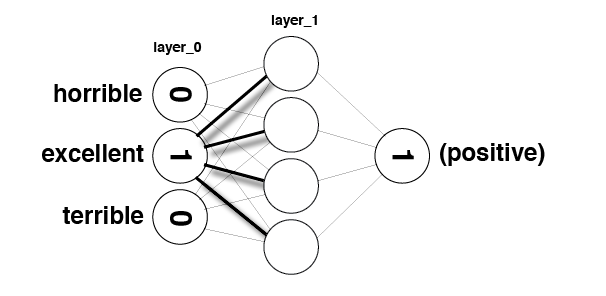

In [16]:
Image(filename='sentiment_network_sparse.png')

In [17]:
def get_most_similar_words(focus = "horrible"):
    most_similar = Counter()

    for word in mlp_full.word2index.keys():
        most_similar[word] = np.dot(mlp_full.weights_0_1[mlp_full.word2index[word]],mlp_full.weights_0_1[mlp_full.word2index[focus]])
    
    return most_similar.most_common()

In [18]:
get_most_similar_words("excellent")[0:50]

[('excellent', 0.1367295075735247),
 ('perfect', 0.12548286087225943),
 ('amazing', 0.09182763392599973),
 ('today', 0.0902236626944142),
 ('wonderful', 0.0893559769622146),
 ('fun', 0.08750446667420686),
 ('great', 0.08714175888229203),
 ('best', 0.08581088561788063),
 ('liked', 0.07769762912384341),
 ('definitely', 0.07662878140696602),
 ('brilliant', 0.07342385876927907),
 ('loved', 0.07328542892812215),
 ('favorite', 0.07278113603616075),
 ('superb', 0.07173620717850505),
 ('fantastic', 0.0709221919162662),
 ('job', 0.06916061720763407),
 ('incredible', 0.06642407795261442),
 ('enjoyable', 0.06563256050288878),
 ('rare', 0.06481921266261506),
 ('highly', 0.06388945335097052),
 ('enjoyed', 0.06212754610181293),
 ('wonderfully', 0.062055178604090155),
 ('perfectly', 0.061093208811887366),
 ('fascinating', 0.060663547937493865),
 ('bit', 0.05965542704565306),
 ('gem', 0.05951085929615678),
 ('outstanding', 0.058860808147083006),
 ('beautiful', 0.05861393470316206),
 ('surprised', 0.05

In [19]:
get_most_similar_words("terrible")[0:50]

[('worst', 0.1696610725904985),
 ('awful', 0.12026847019691247),
 ('waste', 0.11945367265311008),
 ('poor', 0.09275888757443548),
 ('terrible', 0.09142538719772797),
 ('dull', 0.08420927167822362),
 ('poorly', 0.08124154451604204),
 ('disappointment', 0.08006475962136875),
 ('fails', 0.07859977372333754),
 ('disappointing', 0.07733948548032338),
 ('boring', 0.0771278587480129),
 ('unfortunately', 0.07550244970585906),
 ('worse', 0.07060183536419468),
 ('mess', 0.07056429962359043),
 ('stupid', 0.06948482283254304),
 ('badly', 0.06688890366622859),
 ('annoying', 0.06568702190337418),
 ('bad', 0.06309381453757214),
 ('save', 0.06288059749586575),
 ('disappointed', 0.06269235381207287),
 ('wasted', 0.06138718302805129),
 ('supposed', 0.060985452957725145),
 ('horrible', 0.06012177233938014),
 ('laughable', 0.05869840628546765),
 ('crap', 0.05810452866788457),
 ('basically', 0.057218840369636176),
 ('nothing', 0.05715822004303422),
 ('ridiculous', 0.05690548106893146),
 ('lacks', 0.0557665

In [20]:
import matplotlib.colors as colors

words_to_visualize = list()
for word, ratio in pos_neg_ratios.most_common(500):
    if(word in mlp_full.word2index.keys()):
        words_to_visualize.append(word)
    
for word, ratio in list(reversed(pos_neg_ratios.most_common()))[0:500]:
    if(word in mlp_full.word2index.keys()):
        words_to_visualize.append(word)

In [21]:
pos = 0
neg = 0

colors_list = list()
vectors_list = list()
for word in words_to_visualize:
    if word in pos_neg_ratios.keys():
        vectors_list.append(mlp_full.weights_0_1[mlp_full.word2index[word]])
        if(pos_neg_ratios[word] > 0):
            pos+=1
            colors_list.append("#00ff00")
        else:
            neg+=1
            colors_list.append("#000000")

In [22]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
words_top_ted_tsne = tsne.fit_transform(vectors_list)

In [23]:
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="vector T-SNE for most polarized words")

source = ColumnDataSource(data=dict(x1=words_top_ted_tsne[:,0],
                                    x2=words_top_ted_tsne[:,1],
                                    names=words_to_visualize,
                                    color=colors_list))

p.scatter(x="x1", y="x2", size=8, source=source, fill_color="color")

word_labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(word_labels)

show(p)

# green indicates positive words, black indicates negative words